In [1]:
##Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
from scipy import interpolate

##Magic line for in notebook
%matplotlib inline

##Turn on matplotlib's interactive mode
plt.ion()

##Directory for figures
direc = "Figures/ScotlandGrav/"

# Scotland gravity data

Here we investigate Gravity data from Scotland. Data was given by Dr. Hugh Pumphrey. The goal is to investigate the effect of different filters applied on the magnetic field strength data. 

In order to apply these filters, the data must be processed first. The following analysis and processing is applied to evaluate the data:
- Examine data range to identify and eliminate outliers
- Interpolate data to get a continuous spectrum

The following filters are then applied to the data:
- First horizontal and vertical derivatives of field strength by Fourier transforming into the frequency domain
- Second vertical derivative calculated in frequency domain
- Upward and downward continuation to highlight and dampen small scale features respectively
- Pie crust filtering to eliminate linear features
- Strike filtering to highlight linear features

Note: Figures will be saved to a subfolder called "ScotlandGrav" of a folder called "Figures". It needs to be in same directory as notebook.

Furthermore note that the data files are expected to be found in a folder called "Data". 

Folders are the best

In [2]:
#### Loading in data file
fn = "Data/landgrav_ss.csv"

## Cols in file are (counting from 0)
## 0: SURVEY_AREA, 1:STATION_ID, 2:STATION_CODE, 3:LATITUDE, 4:LONGITUDE,
## 5:GRID_EAST, 6:GRID_NORTH, 7:STATION_ELEV, 8:ELEVATION_UNIT,
## 9:BOUGUER_DENS, 10:BASE_CODE, 11:OBSERVED_GRAV, 12:FREE_AIR_AN,
## 13:ITOT_TC, 14:ITOT_TCZ, 15:TOT_TC, 16:TOT_TCZ, 17:BOUGUER_AN,
## 18:SOURCE_CODE, 19:READING_DATE, 20:GRS, 21:NTC

dat=np.genfromtxt(fn,delimiter=",",skip_header=1,usecols=(5,6,17))

## Distributing data into relevant arrays
east=dat[:,0]
north=dat[:,1]
boug=dat[:,2]

## Labels relevant for later plots
eastlabel = "Easting (km)"
northlabel = "Northing (km)"

In [3]:
## Check whether array distribution seems realistic
df = pd.DataFrame(dat).head()
print(df)

          0         1      2
0  258800.0  558590.0   9.33
1  242160.0  558310.0  10.86
2  260520.0  547120.0  22.93
3  268850.0  557280.0  13.93
4  265610.0  557360.0  14.64


In [4]:
## Check range of easting and northing of data
erange = np.round(np.max(east)-np.min(east), 2)
nrange = np.round(np.max(north)-np.min(north), 2)

print("easting range: " + str(np.round(np.min(east),2)) + " to " + str(np.round(np.max(east),2))+ "m. Total range: " 
      + str(erange))
print("northing range: " + str(np.round(np.min(north),2)) + " to " + str(np.round(np.max(north),2)) + "m. Total range: " 
      + str(nrange))

## Print the minimum range. This becomes important when we prepare to Fourier transform the data, which requires the
## the data to be in a sqaure
_range = np.min((erange,nrange))
print(_range)

easting range: 220010.0 to 419970.0m. Total range: 199960.0
northing range: 536060.0 to 735990.0m. Total range: 199930.0
199930.0


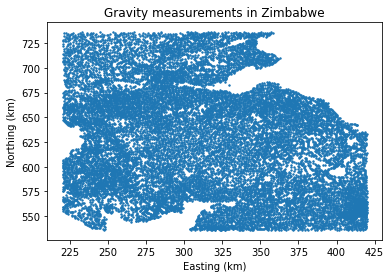

In [5]:
##Plot positions of measurement points

plt.figure(1)

plt.scatter(east/1000, north/1000, s = 2)
plt.title("Gravity measurements in Zimbabwe")
plt.xlabel(eastlabel)
plt.ylabel(northlabel)
plt.savefig(direc + "locations_UTM")

## Investigating the range of gravity data to determine outliers

In order to inspect the distribution of Bouguer anomalies gathered, the most insightful method is to produce a boxplot

minimum bouguer anomaly: -41.52


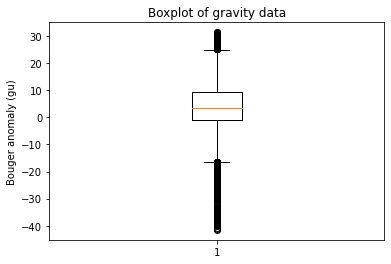

In [6]:
print("minimum bouguer anomaly: " + str(np.min(boug)))

boxplot = plt.boxplot(boug)
plt.ylabel("Bouger anomaly (gu)")
plt.title("Boxplot of gravity data")
plt.show()

The distribution of bouguer anomalies seems reasoable, and no outliers needs to be corrected and dealt with. 

## Plotting gravity contours

Here we want to plot a basic contour map of the gravity data to see the bouguer distribution over Scotland. This will as well work as a sanity check to the interpolated and filtered maps produced later. 

<Figure size 432x288 with 0 Axes>

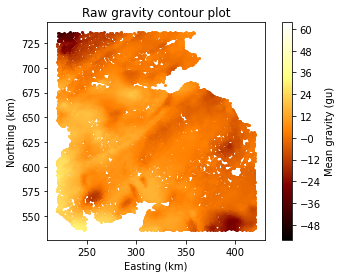

In [7]:
### Choose contour levels to use
var = 60
levs = np.arange(np.mean(boug)-var, np.mean(boug)+var, 0.2)
###### This produces coloured scatter plot of data ######
if(True):
    ## choose which set of colours to use
    cmap = plt.cm.afmhot
    plt.set_cmap(cmap)

    #plt.figure(1)
    #plt.clf()
    
    nl = len(levs)
    vals = (levs[0:(nl-1)]+levs[1:nl])/2
    cols = cmap(np.linspace(1.0/(nl+1),nl/(nl+1.0),nl-1))
    
    fig, ax = plt.subplots()
    
    ax.set_title("Raw gravity contour plot")
    ax.set_xlabel(eastlabel)
    ax.set_ylabel(northlabel)

    ## Plot the points
    for i in range(0,len(levs)-1):
        ix = np.where((boug>levs[i]) * (boug <= levs[i+1]))
        ax.plot(east[ix]/1000,north[ix]/1000,"o",markersize=2,color=cols[i])
        
        
        ## This is just so that the map scale is the same in both E-W and N-S
        ax.set_aspect("equal")

    ## Add colour bar.
    sm = plt.cm.ScalarMappable(cmap = cmap,
                               norm = plt.Normalize(vmin=levs[0],
                                                    vmax=levs[nl-1]))
    sm._A = []
    plt.colorbar(sm,boundaries=levs,values=vals, label = "Mean gravity (gu)")
    ### Scatter plot finished
    

In order to Fourier transform the data, we need to cut down the grid into a square with increments that is a multiple of 2. 

In [8]:
##### Preparing the data for ffts by creating equally spaced square grid #####
nx = 256
ny = 256
sqsize=180000   ### Size of square in metres
emin=220000     ### Easting of SW corner
emax=emin+sqsize
nmin=559000     ### Northing of SW corner
nmax=nmin+sqsize

## Cut the original data down to the region we care about
## This region is chosen in conjunction with the magnetics data
print("pruning... ")
border = 100000
i1 = north > (nmin - border)
i2 = north < (nmax + border)
i3 = east > (emin - border)
i4 = east < (emax + border)
i5 = np.logical_and(i1, i2)
i6 = np.logical_and(i3, i4)
ix = np.where(np.logical_and(i5, i6))[0]


## For the purposes of deconvolution, we define an origin for 
## x, y coordinates in the middle of the region

xorig = emin + sqsize/2
yorig = nmin + sqsize/2
## Note: With the time given for this project, we have not dealt with euler deconvolution, so the two
## lines above are not important for our code, but is for future years. 

## Creating a mesh-grid with our defined sizes
geast  = np.linspace(emin, emax, nx)
gnorth = np.linspace(nmin, nmax, ny)
ggeast, ggnorth = np.meshgrid(geast, gnorth)
dx = geast[1] - geast[0]
dy = gnorth[1] - gnorth[0]
dk = 1/(nx*dx) ## spatial frequency increments - becomes important in fourier transformations.


east = east[ix]
north = north[ix]
boug = boug[ix]
print("... Done pruning")


## Interpolation the data
### Note: Comparing triangulation and Clough Tocher2D interpolation to what method
###       is preferable

#### Clough Toucher 2D Interpolation
print("Interpolating...")
interp = interpolate.CloughTocher2DInterpolator((east, north), boug)
gbougCT = interp(ggeast, ggnorth)
print("... Done interpolation")
#### Triangulation using matplotlib's tri interpolator
print("Triangulating...")
triang = tri.Triangulation(east,north)
foo = tri.LinearTriInterpolator(triang,boug)
gbougTri = foo(ggeast,ggnorth)
print("... Done triangulating")



pruning... 
... Done pruning
Interpolating...
... Done interpolation
Triangulating...
... Done triangulating


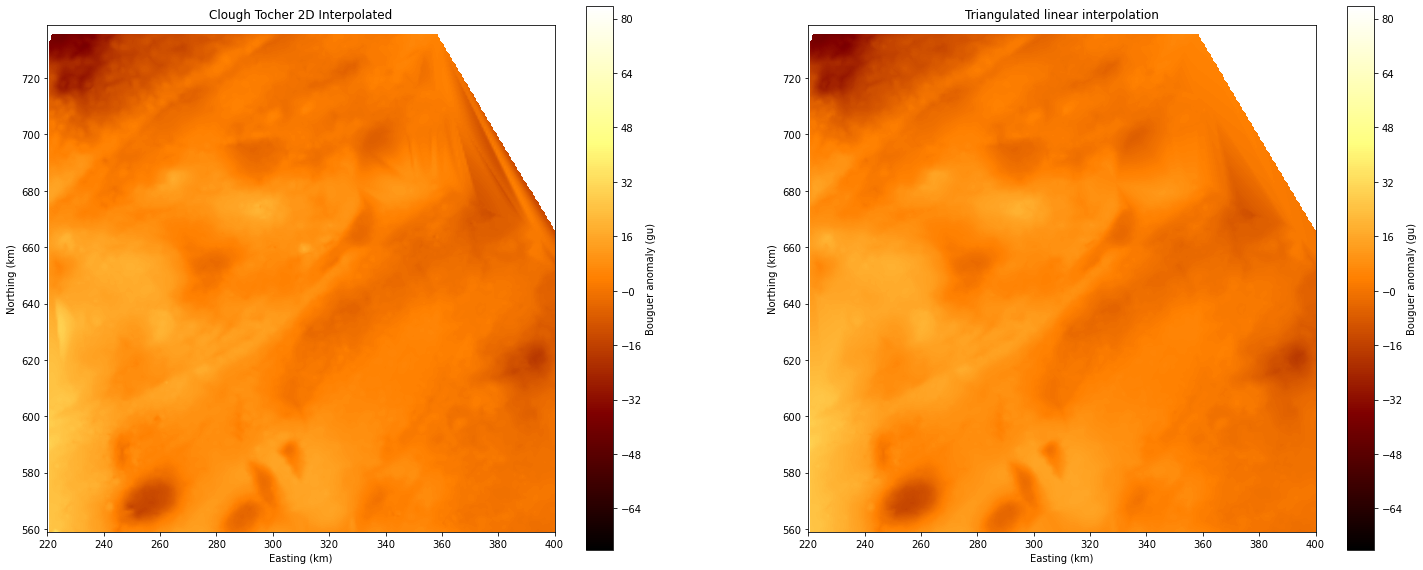

Data points in region: 17997
Area of interest: 32400.0km^2
Data density : 0.555 points per km^2


In [9]:
## Plotting interpolated field
var = 80
levs = np.arange(np.mean(boug)-var, np.mean(boug)+var, 0.2)

fig, axs = plt.subplots(1,2, figsize = [25, 10])

im0 = axs[0].contourf(geast/1000, gnorth/1000, gbougCT, levs)
axs[0].set(title="Clough Tocher 2D Interpolated")
im1 = axs[1].contourf(geast/1000, gnorth/1000, gbougTri, levs)
axs[1].set(title="Triangulated linear interpolation")
for i in range(2):
    im = [im0, im1]
    axs[i].set(xlabel = eastlabel, ylabel = northlabel, aspect = "equal")
    bar = plt.colorbar(im[i], ax = axs[i], label = "Bouguer anomaly (gu)")

plt.show()

print("Data points in region: " + str(len(ix)))
print("Area of interest: " + str((sqsize/1000)**2)+"km^2")
print("Data density : " + str(np.round(len(ix)/((sqsize/1000)**2), 3)) + " points per km^2")

Here we see the interpolated bouguer anomaly. The Clough Tocher 2D interpolation is plotted next to the Triangulation Linear interpolator in the matplotlib library. We see that the triangulation method is more stable, and will be the one to use.  The greenstone belt is much more apparent, running down the left side as well as the shear belts in the bottom. There are some interesting highly magnetic intrusions scattered arount the map as well. 

In [10]:
gboug = gbougTri

## Calculating and plotting 1st and 2nd derivatives 

Calculation of horizontal derivative. The directional derivative wrt to one component in the space domain is equivalent to multiplication of $2\pi k$ in the frequency domain, where k is the wave number

$$ \frac{\partial^n U(x_1, x_2, x_3)}{\partial x_i^n} \leftrightarrow (2\pi i k_i)^n \hat{U}(k_1, k_2, k_3)$$

in which $k_i$ is the wave number fourier transfered from the spatial direction $x_i$ and the hat represents U in the frequency domain. 

Calculation of the vertical derivative. 
The nth vertical derivative can be found by multiplying the fourier transformed data by the radial wavenumber.
$F(\frac{\partial^nU}{\partial z^n}) = F(U)  |k_r|  ^n$ where $|k_r| = \sqrt{k_x^2 + k_y^2}$

The second Vertical gradient can also calculated by assuming Poisson's equation. 
$\nabla ^2 U = 0 \implies \frac{\partial^2U}{\partial z^2} = -\frac{\partial^2U}{\partial x^2} - \frac{\partial^2U}{\partial y^2}$

In [11]:
### Next we need to calculate the three gradients. Before doing this
### we tidy the data up a bit.
print("Calculating gradients...")

## First, subtract the mean value:
gboug = gboug - np.mean(gboug)

## Next we set all nans to 0. This should allow us to do regions that
## have a bit of sea in the corner.

isbad=np.isnan(gboug)
gboug[isbad]=0

## Then, we taper data down to zero at edges to avoid nasty edge effects
winw = 7000 

## This is the width of the taper in grid points
ntaper=int(np.floor(winw/dx))

xfilt = geast*0+1

ix = np.where(geast-geast[0] <= winw)
xfilt[ix] = np.sin(0.5*np.pi*(geast[ix]-geast[0])/winw)**2

ix = np.where(geast[nx-1]-geast <= winw)
xfilt[ix] = np.sin(0.5*np.pi*(geast[nx-1]-geast[ix])/winw)**2
winfilt= np.outer(xfilt,xfilt)
gboug = gboug*winfilt
gboug0 = gboug ## This is marking field strength at measured height. Becomes relevant in
               ## upward continuation

## Calculate X and Y gradients. We use a 1-D FFT for this
kxboug = np.fft.fft(gboug,axis=1)*dx
kyboug = np.fft.fft(gboug,axis=0)*dy
kx = np.concatenate((np.linspace(0, (nx//2)*dk, 1 + nx//2),
                   np.linspace(dk*(1-nx//2), -dk, -1 + (nx//2))))
ky = np.concatenate((np.linspace(0, (ny//2)*dk, 1 + ny//2),
                   np.linspace(dk*(1-ny//2), -dk, -1 + (ny//2))))

### Multiply by 2 pi i k to get FT of gradient
kxg,kyg = np.meshgrid(kx,ky)
kdxboug = kxboug*kxg*(0+1j)*2*np.pi
kdyboug = kyboug*kyg*(0+1j)*2*np.pi


### Multiply by 2 pi i k to get 2nd derivatives
kdx2boug = kdxboug*kxg*(0+1j)*2*np.pi
kdy2boug = kdyboug*kyg*(0+1j)*2*np.pi

## Force value at Nyquist freq to zero
kdxboug[:,nx//2]=0
kdyboug[ny//2,:]=0
kdx2boug[:,nx//2]=0
kdy2boug[ny//2,:]=0

## Inverse transform to get gradient. 
gdxboug = np.fft.ifft(kdxboug,axis=1)*nx*dk
gdyboug = np.fft.ifft(kdyboug,axis=0)*ny*dk
gdx2boug = np.fft.ifft(kdx2boug,axis=1)*nx*dk
gdy2boug = np.fft.ifft(kdy2boug,axis=0)*ny*dk

## Calculate the Z gradient.
kzg = np.sqrt(kxg*kxg + kyg*kyg)
kzboug = np.fft.fft2(gboug)*dx*dy
kdzboug = kzboug*2*np.pi*kzg
gdzboug = np.fft.ifft2(kdzboug)*dk*dk*nx*ny

## Calculate the 2nd Z derivative

#### Calculate the 2nd Z gradient using 2D FFT
kdz2boug = kzboug*2*np.pi*kzg**2
gdz2boug = np.fft.ifft2(kdz2boug)*dk*dk*nx*ny
#### Calculate the 2nd Z gradient using Poisson's equation
gdz2bougpoisson = -(gdx2boug + gdy2boug)

## Force gradient to be real. Numerical roundoff leads to tiny
## imaginary parts if we don't do this.
gdxboug=gdxboug.real
gdyboug=gdyboug.real
gdzboug=gdzboug.real
gdx2boug=gdx2boug.real
gdy2boug=gdy2boug.real
gdz2boug=gdz2boug.real
gdz2bougpoisson=gdz2bougpoisson.real


print("... gradients calculated")

Calculating gradients...
... gradients calculated


C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

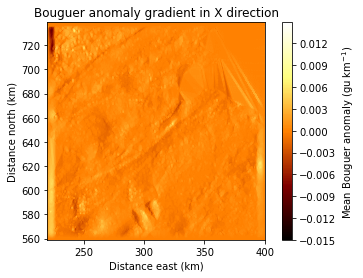

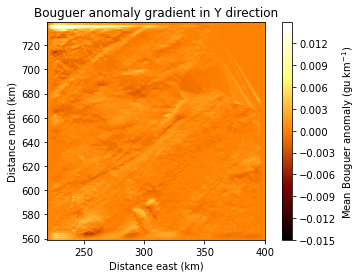

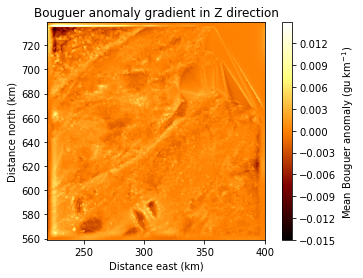

In [12]:
#### Plot deriavatives

##Titles and stuff
xlabel = "Distance east (km)"
ylabel = "Distance north (km)"
barlabel = "Mean Bouguer anomaly (gu km$^{-1}$)"
title = "Bouguer anomaly gradient in "
levs = np.arange(-0.015,0.015, 0.0001)
##X derivative
plt.figure(3)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdxboug, levs)

plt.title(title + "X direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

##Y derivative
plt.figure(4)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdyboug, levs)

plt.title(title + "Y direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

##Z derivative
plt.figure(5)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdzboug, levs)

plt.title(title + "Z direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


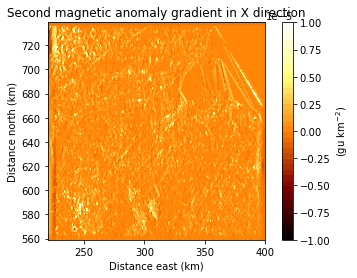

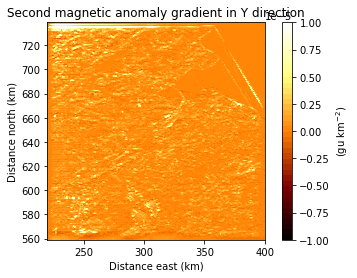

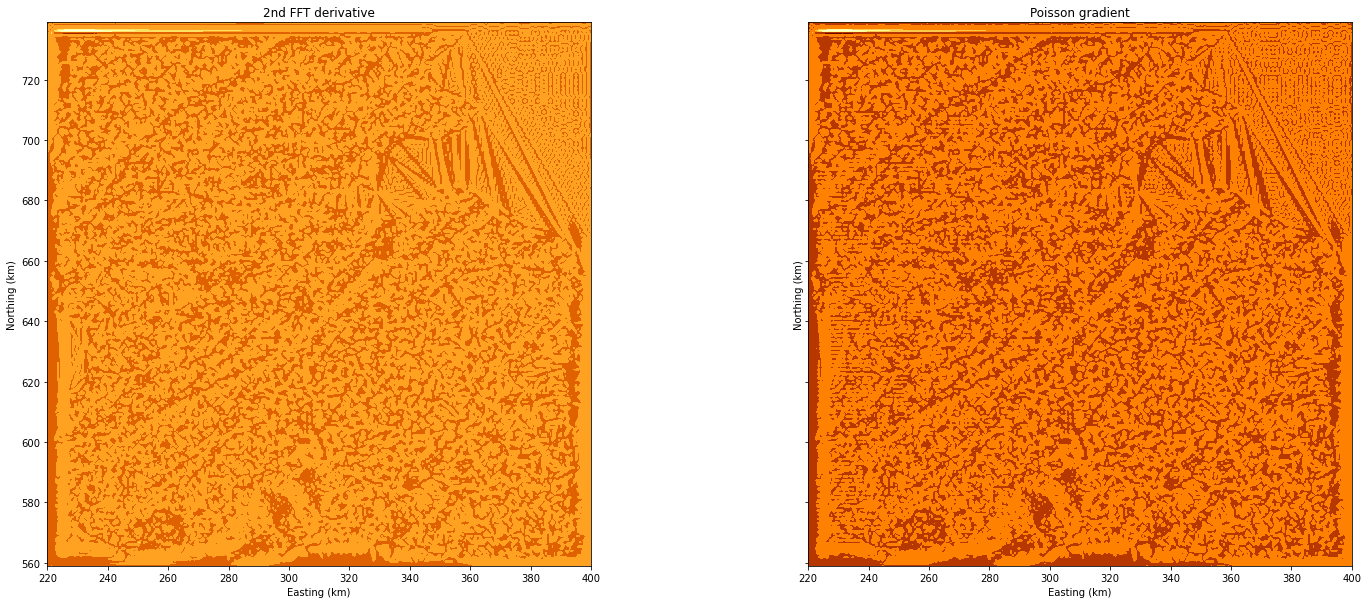

In [13]:
#### Plotting second derivatives

##Titles and stuff
xlabel = "Distance east (km)"
ylabel = "Distance north (km)"
barlabel = "(gu km$^{-2}$)"
title = "Second magnetic anomaly gradient in "
levs = np.arange(-1e-5,1e-5,5e-7)
##X derivative
plt.figure(6)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdx2boug, levs)

plt.title(title + "X direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar=plt.colorbar(label=barlabel)

##Y derivative
plt.figure(7)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdy2boug, levs)

plt.title(title + "Y direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

##Z derivative
fig, axs = plt.subplots(1,2, sharey = True, figsize = [25, 10])
im0 = axs[0].contourf(geast/1000, gnorth/1000, gdz2boug)#, levs)
im1 = axs[1].contourf(geast/1000, gnorth/1000, gdz2bougpoisson)# levs)
#bar = plt.colorbar(im1, ax = axs[1], label = "gu km$^{-2}$")
for i in range(2):
                      title = ["2nd FFT derivative", "Poisson gradient"]
                      axs[i].set(xlabel = eastlabel, ylabel = northlabel, title = title[i], aspect = "equal")

## Upward Continuation

Upward continuation is done by convolving the potential field with $e^{-H k}$, in which $H$ is the height we wish to synthetically measure the potential at, and $k^2 = k_1^2 + k_2^2$. From the convolution theorem, convolution in the spatial domain is multiplication in the (spatial)-frequency domain. 

NOTE: Since aeromagnetic data is gathered in air, it's possible to downward continue data to ground level by upward continuing by $-H$. 

In [14]:
## Define funtion for upward continuation
def UpwardContinuation(H, gboug0):
    '''Function which takes bouguer anomaly measured at ground level and returns upward continued data at input height H.
    This is done using a 2D Fourier transform and multiplying by height factor e^(-Hk)'''
    from scipy.fftpack import fft2, ifft2, fftfreq
    
    #### Moving the gravity measurements by a height H ####
    
    ## Take 2D FFT of bouguer anomaly
    kbougH = fft2(gboug)         #2D FFT
    n_value = fftfreq(nx, (1/nx)) #Gives frequencies of 2D FFT
    
    ## Initialise arrays to hold wave no. coordinates of each cell
    kx_array = np.zeros((nx,nx), dtype = float)
    ky_array = np.zeros((ny,ny), dtype = float)
    k_array  = np.zeros((nx,ny), dtype = float)
    
    ## Defining length of spatial domain. This assumes spatial domain unit is metres
    x_len = sqsize
    y_len = sqsize
    
    ## Loops to calculate wave no.s
    for row in range(nx):
        for col in range(nx):
            kx_array[row][col] = (2.0 * np.pi * n_value[col])/x_len
            ky_array[row][col] = (2.0 * np.pi * n_value[row])/y_len
            
            #Pythagoras to find total vertical wave no.
            k_array[row][col] = np.sqrt(kx_array[row][col]**2 + ky_array[row][col]**2)
    ## Now kx, ky and k hold the wave domain coordinates of corresponding gmag in k-domain
    
    ## Upward continuation
    kbougH = kbougH * np.exp(-H*k_array)
    
    ## Forcing Nyquist frequency to zero
    kbougH[:,nx//2] = 0
    kbougH[ny//2,:] = 0
    
    ## Inverse FFT back to space domain and force data to be real
    gbougH = ifft2(kbougH)
    gbougH = gbougH.real
    
    return(gbougH)
    
    


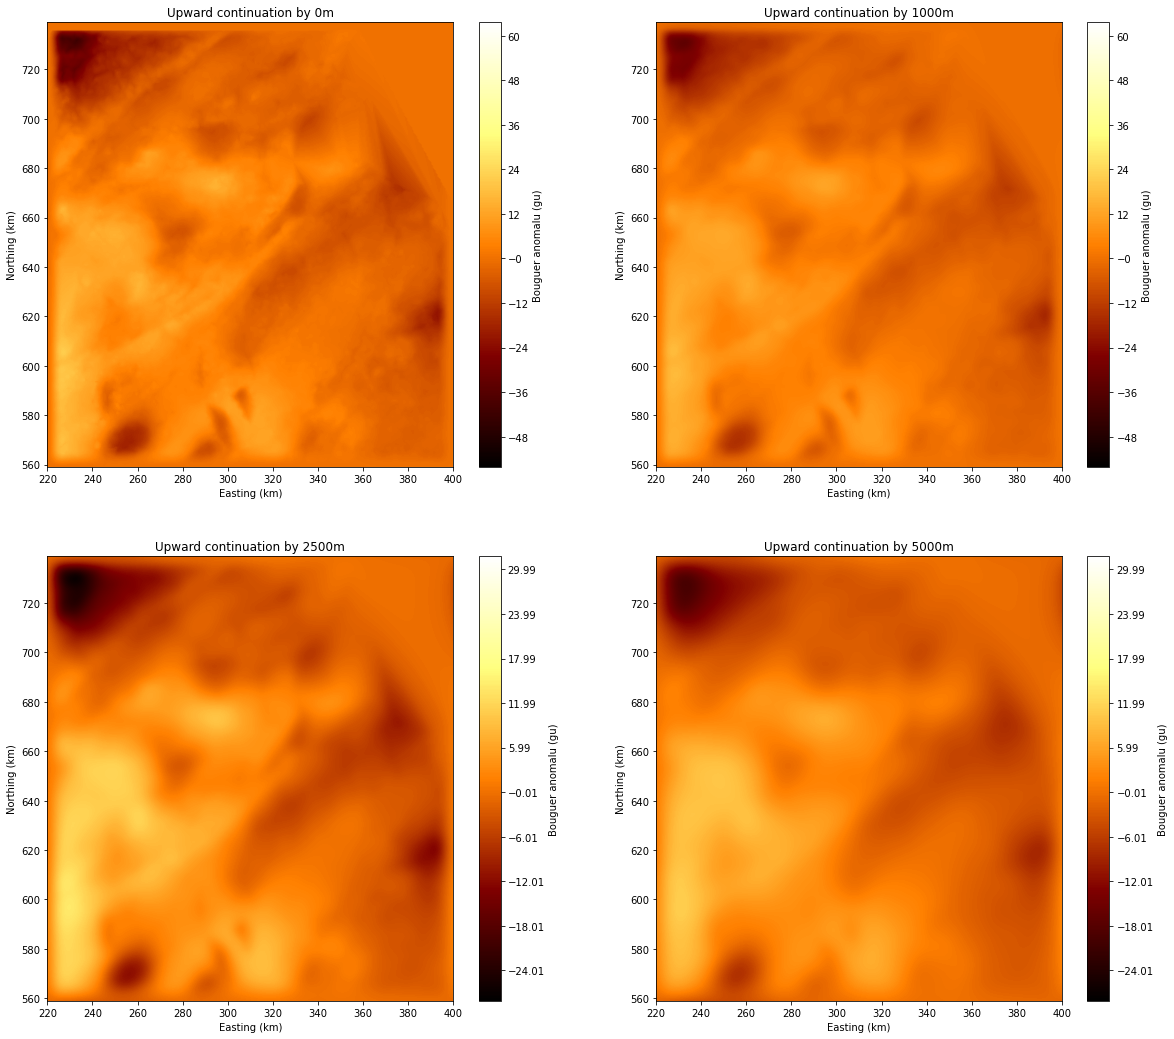

In [15]:
## Upward and downward continuate data
var = 60
levs = np.arange(np.mean(boug)-var, np.mean(boug)+var, 0.2)

fig, axs = plt.subplots(2,2, figsize = [20, 18])
Hs = np.array([[0, 1000], [2500, 5000]])

for i in range(2):
    for j in range(2):
        im = axs[i,j].contourf(geast/1000, gnorth/1000, UpwardContinuation(Hs[i,j], gboug0), levs/(i+1))
        bar = plt.colorbar(im, ax=axs[i,j], label = "Bouguer anomalu (gu)")
        axs[i,j].set(xlabel = eastlabel, ylabel = northlabel, title = "Upward continuation by " + str(Hs[i,j]) + "m")
        

## Strike filtering

Strike filtering is done by convolving the potential field by $e^{-Hk|{\cos(\theta) + \phi}|}$ in the spatial domain, where $\theta$ is the angle of which we wish to enhance and $\phi = \tan^-1(\frac{k_1}{k_2})$. $H$ is the height we need to apply the strike filter at and $k^2 = k_1^2 + k_2^2$ as before. Again, by the convolution theorem, we are gonna multiply this in the spatial frequency domain and then inverse transfer to achieve this convolution.

In [16]:
## Define function for pie crust filtering
def StrikeFilter(theta, H, gboug0):
    '''Function that upward continues by height H and then enhances features which strike at an angle
    theta (given in degrees). This is done using a 2D Fourier transform and multiplying by factor 
    e^(-Hk|cos(theta)+phi), in which phi is arctan(k_x, k_y)'''
    import math
    from scipy.fftpack import fft2, ifft2, fftfreq
    
    ## Converting theta into radians
    thet = np.radians(theta)
    
    ## Take 2D FFT of magnetic data
    kbougS = fft2(gboug0)         #2D FFT
    n_value = fftfreq(nx, (1/nx)) #Gives frequencies of 2D FFT
    
    ## Initialise arrays to hold wave no. coordinates of each cell
    kx_array = np.zeros((nx,nx), dtype = float)
    ky_array = np.zeros((ny,ny), dtype = float)
    k_array  = np.zeros((nx,ny), dtype = float)
    phi_array= np.zeros((nx,ny), dtype = float)
    
    ## Defining length of spatial domain. This assumes spatial domain unit is metres
    x_len = sqsize
    y_len = sqsize
    
    ## Loops to calculate wave no.s
    for row in range(nx):
        for col in range(nx):
            kx_array[row][col] = (2.0 * np.pi * n_value[col])/x_len
            ky_array[row][col] = (2.0 * np.pi * n_value[row])/y_len
            
            ## Pythagoras to find total vertical wave no.
            k_array[row][col] = np.sqrt(kx_array[0][row]**2 + ky_array[0][col]**2)
            
            ## Arctan of kx/ky to find phi
            
            phi_array[row][col] = math.atan2(kx_array[row][col],ky_array[row][col])
            
    ## Now kx, ky, k and phi hold the wave domain coordinates of corresponding gmag in k-domain
    
    ## Apply strike filter
    kbougS = kbougS * np.exp(-H*k_array*abs(np.cos(thet)+phi_array))
    
    ## Forcing Nyquist frequency to zero
    kbougS[:,nx//2] = 0
    kbougS[ny//2,:] = 0
    
    ## Inverse FFT back to space domain and force data to be real
    gbougS = ifft2(kbougS)
    gbougS = gbougS.real
    
    return gbougS
    
    
    

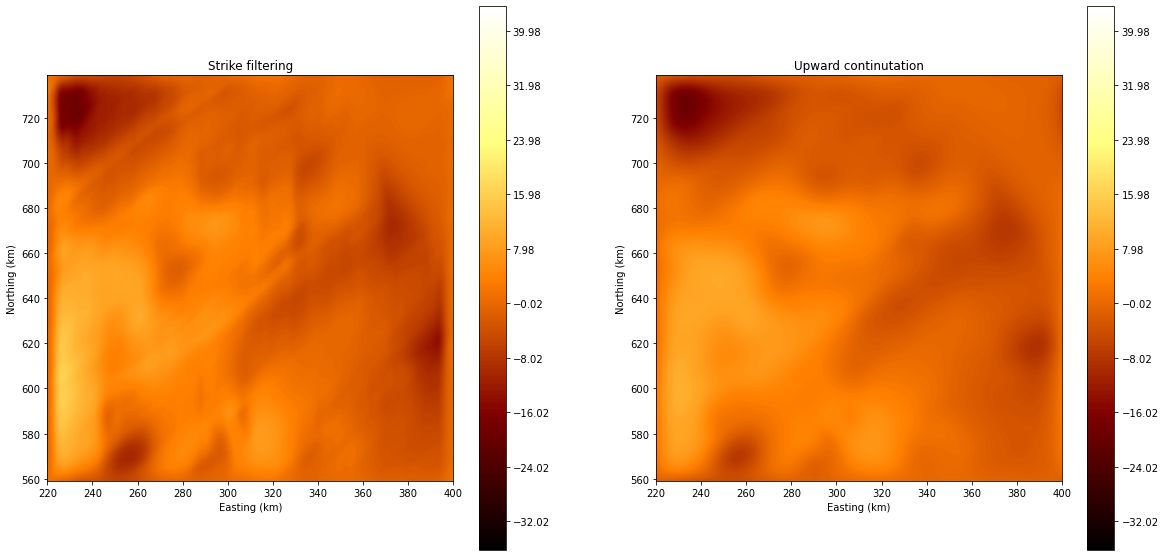

In [17]:
## Plot pie crust filtered data with
angle = 45 #degrees
height= 5000 #metres

var = 40
levs = np.arange(np.mean(boug)-var, np.mean(boug)+var, 0.2)

fig, axs = plt.subplots(1,2, figsize = [20, 10])
im0 = axs[0].contourf(geast/1000, gnorth/1000, StrikeFilter(angle, height, gboug0), levs)
axs[0].set_title("Strike filtering")
im1 = axs[1].contourf(geast/1000, gnorth/1000, UpwardContinuation(height, gboug0), levs)
axs[1].set_title("Upward continutation")
for i in range(2):
    im = [im0, im1]
    bar = plt.colorbar(im[i], ax = axs[i])
    axs[i].set(xlabel = eastlabel, ylabel = northlabel, aspect = "equal")


## Pie crust filtering

In [18]:
def PieCrustFilter(angle, dangle, gboug0):
    '''Function that multiplies interpolated potential data by 0 when striking at given angle
    +- dangle and everything else by 1. This is done 2D Fourier Transforming potential data and multiplying
    pie crust filter in frequency domain'''
    import math
    from scipy.fftpack import fft2 ,ifft2, fftfreq
    
    ## Converting angles into radians
    phi0 = np.radians(angle+90)
    dphi = np.radians(dangle)
    
    ## Take 2D Fourier transform of potential data
    kbougP = fft2(gboug0)          ## 2D FFT
    n_value = fftfreq(nx, (1/nx))  ## Gives frequencies of 2D FFT
    
    ## Initialise arrays to hold wave no. coordinates of each cell
    kx_array = np.zeros((nx,nx), dtype = float)
    ky_array = np.zeros((ny,ny), dtype = float)
    k_array  = np.zeros((nx,ny), dtype = float)
    phi_array= np.zeros((nx,ny), dtype = float)
    
    ## Defining length of spatial domain. This assumes spatial domain unit is metres
    x_len = sqsize
    y_len = sqsize
    
    ## Loops to calculate wave no.s
    for row in range(nx):
        for col in range(nx):
            kx_array[row][col] = (2.0 * np.pi * n_value[col])/x_len
            ky_array[row][col] = (2.0 * np.pi * n_value[row])/y_len
            
            ## Arctan of kx/ky to find phi
            
            phi_array[row][col] = math.atan2(kx_array[row][col],ky_array[row][col])
            
    ## Now kx, ky, k and phi hold the wave domain coordinates of corresponding gmag in k-domain
    
    ## Define wedge function W(phi) in which Pie Crust filter acts. Below is the W function
    def W(phi_array, phi0, dphi):
        with np.nditer(phi_array, op_flags=['readwrite']) as it:
            for phi in it:
                if (phi0 - dphi) < phi:
                    if phi < (phi0 + dphi):
                        phi[...] = 0
                    else:
                        phi[...] = 1
                elif (phi0 - dphi) < (phi + np.pi):
                    if (phi + np.pi) < (phi0 + dphi):
                        phi[...] = 0
                    else:
                        phi[...] = 1
                else:
                        phi[...] = 1
        return phi_array
    
    ## Apply Pie Crust filter
    pie_crust = W(phi_array, phi0, dphi)
    kbougP = np.multiply(kbougP,pie_crust)
    
    ## Forcing Nyquist frequency to zero
    kbougP[:,nx//2] = 0
    kbougP[ny//2,:] = 0
    
    ## Inverse FFT back to space domain and force data to be real
    gbougP = ifft2(kbougP)
    gbougP = gbougP.real
    
    return(gbougP)
    
    

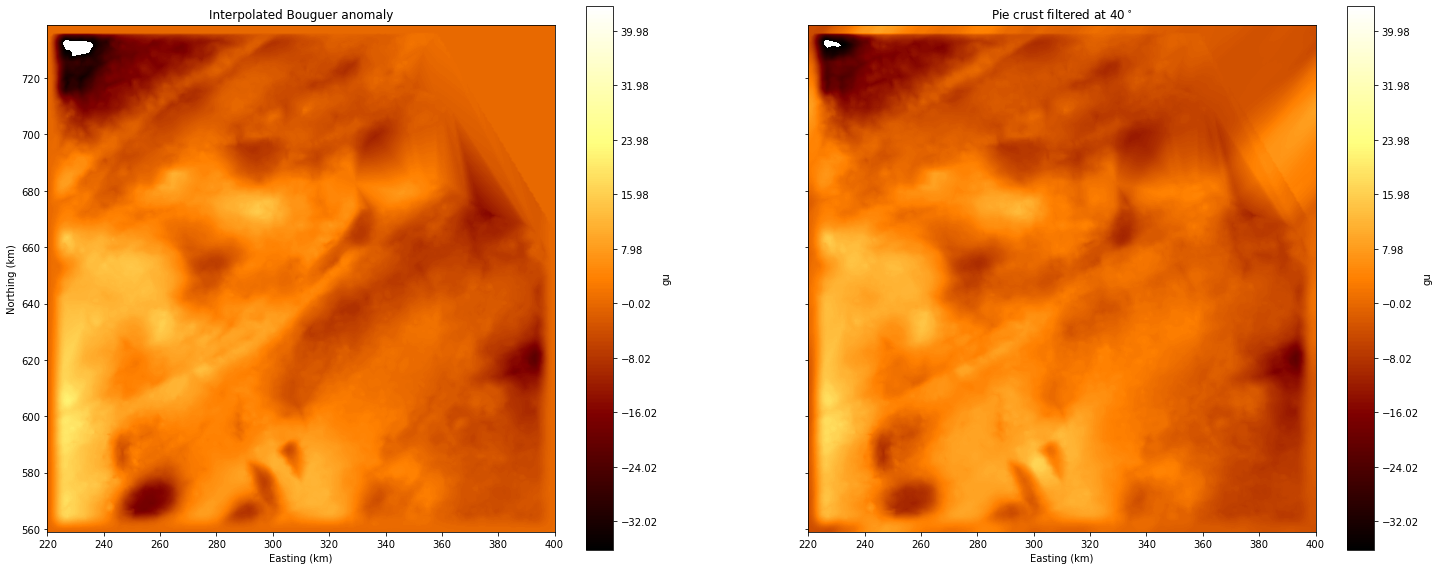

In [19]:
## Apply and compare Pie crust filtered data to raw interpolated data
angle = 40 #degrees
dangle= 10 #degrees

var = 40
levs = np.arange(np.mean(boug)-var, np.mean(boug)+var, 0.2)

fig, axs = plt.subplots(1,2, sharey = True, figsize = [25, 10])

im0 = axs[0].contourf(geast/1000, gnorth/1000, gboug0, levs)
axs[0].set(xlabel = eastlabel, ylabel = northlabel, title = "Interpolated Bouguer anomaly", aspect ="equal")
im1 = axs[1].contourf(geast/1000, gnorth/1000, PieCrustFilter(angle, dangle, gboug0), levs)
axs[1].set(xlabel = eastlabel, title = "Pie crust filtered at " + str(angle)+"$^\circ$", aspect = "equal")
for i in range(2):
    im = [im0, im1]
    bar = plt.colorbar(im[i], ax =axs[i], label = "gu")
